**Time Series Forecasting for Stock Prices**

In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Fetch stock data (Apple, 5 years)
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2025-05-24', progress=False)
data = stock_data[['Close']].copy()

# Explore the data
print("Stock Data Info:")
print(data.info())
print("\nSample Data:")
print(data.head())
print("\nSummary Statistics:")
print(data.describe())

YF.download() has changed argument auto_adjust default to True
Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1356 entries, 2020-01-02 to 2025-05-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  1356 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB
None

Sample Data:
Price           Close
Ticker           AAPL
Date                 
2020-01-02  72.620834
2020-01-03  71.914818
2020-01-06  72.487846
2020-01-07  72.146935
2020-01-08  73.307495

Summary Statistics:
Price         Close
Ticker         AAPL
count   1356.000000
mean     156.905111
std       44.399180
min       54.378586
25%      128.780853
50%      155.431076
75%      184.831173
max      258.396667


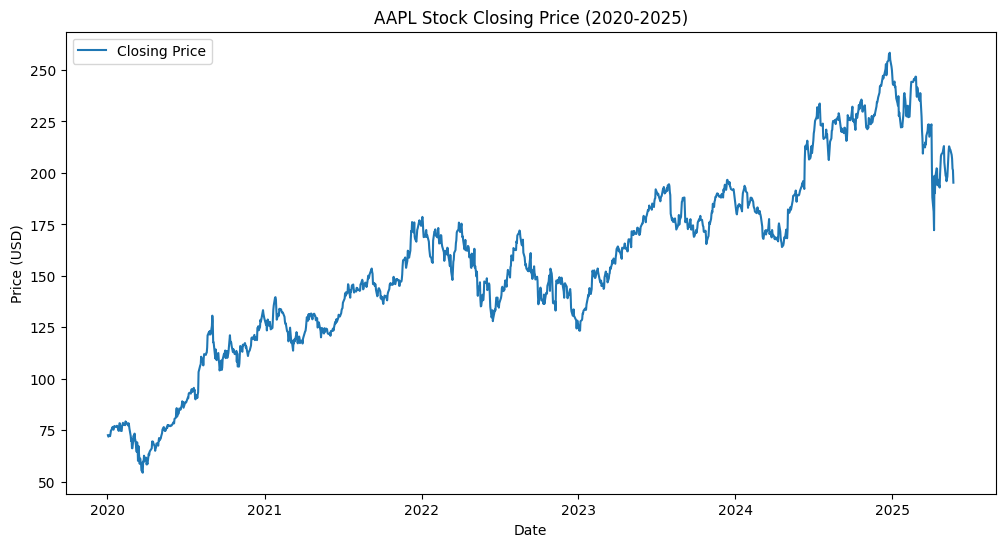

In [3]:
# Visualize historical closing prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Closing Price (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [4]:
# Preprocess data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences (60-day window, predict next day)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [5]:
# Split data (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1036, 60, 1)
Test set shape: (260, 60, 1)


In [6]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)

# Evaluate model
y_pred = model.predict(X_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0646 - val_loss: 6.7685e-04
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0026 - val_loss: 7.4245e-04
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0023 - val_loss: 6.2297e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0020 - val_loss: 6.3278e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0020 - val_loss: 7.5467e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0020 - val_loss: 5.7878e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0016 - val_loss: 6.7377e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0016 - val_loss: 7.9815e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0015 - val_loss: 5.6785e-04
Epoch 12/20
30/30 ━━━━━━━━

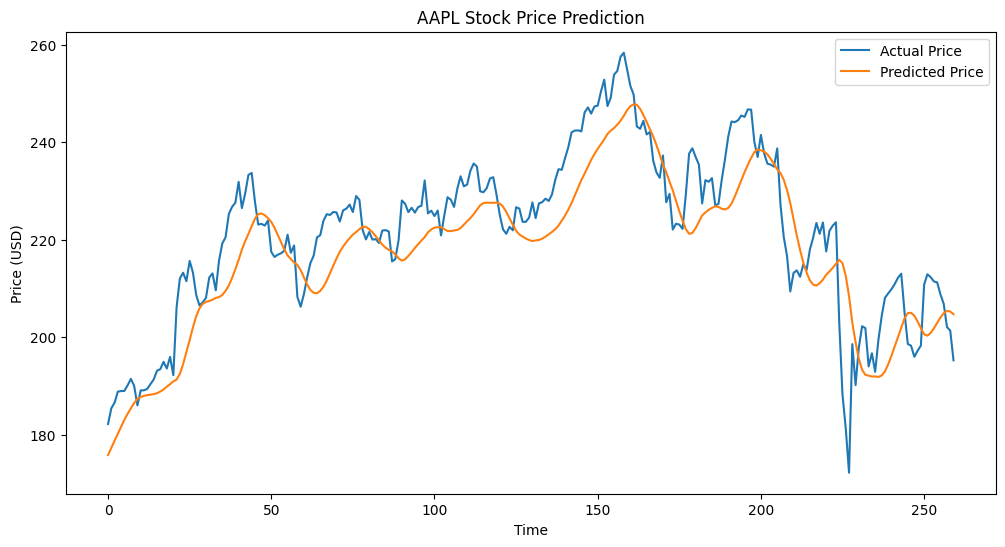

In [8]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Price')
plt.plot(y_pred_unscaled, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

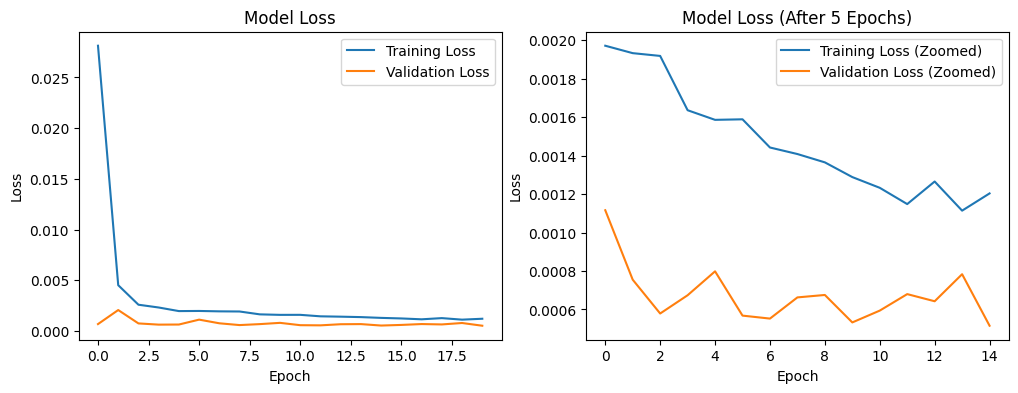

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][5:], label='Training Loss (Zoomed)')
plt.plot(history.history['val_loss'][5:], label='Validation Loss (Zoomed)')
plt.title('Model Loss (After 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Interactive forecasting
print("\nForecast Future Stock Prices:")
ticker_input = widgets.Text(value='AAPL', description='Ticker:')
days_input = widgets.IntSlider(value=5, min=1, max=30, description='Days:')
predict_button = widgets.Button(description="Forecast")
output = widgets.Output()

def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        ticker = ticker_input.value
        days = days_input.value

        # Fetch latest data
        stock_data = yf.download(ticker, start='2020-01-01', end='2025-05-24', progress=False)
        data = stock_data[['Close']].copy()
        scaled_data = scaler.transform(data)

        # Prepare input (last 60 days)
        last_sequence = scaled_data[-seq_length:]
        X_forecast = [last_sequence]
        forecast = []

        # Forecast n days
        for _ in range(days):
            X_input = np.array(X_forecast[-1]).reshape(1, seq_length, 1)
            pred = model.predict(X_input, verbose=0)
            forecast.append(pred[0, 0])
            X_forecast.append(np.roll(X_forecast[-1], -1))
            X_forecast[-1][-1] = pred[0, 0]

        # Unscale predictions
        forecast_unscaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

        # Generate future dates
        last_date = data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='B')

        # Plot forecast
        plt.figure(figsize=(10, 5))
        plt.plot(data.index[-100:], data['Close'][-100:], label='Historical Price')
        plt.plot(future_dates, forecast_unscaled, label='Forecasted Price', marker='o')
        plt.title(f'{ticker} Stock Price Forecast ({days} Days)')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.show()

        # Display forecast
        print("Forecasted Prices:")
        for date, price in zip(future_dates, forecast_unscaled):
            print(f"{date.date()}: ${price[0]:.2f}")

predict_button.on_click(on_predict_button_clicked)
display(ticker_input, days_input, predict_button, output)


Forecast Future Stock Prices:


Text(value='AAPL', description='Ticker:')

IntSlider(value=5, description='Days:', max=30, min=1)

Button(description='Forecast', style=ButtonStyle())

Output()